In [1]:
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from scipy.interpolate import RectBivariateSpline
folder = '../flydrive/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble'
t0 = np.load(f'{folder}/t.npy')
m0 = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')
v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')

print(t0.shape, m0.shape, v0.shape)

from morphogenesis.forecasting.transforms import EmbryoGradient

div_m = np.einsum('tijyxj->tiyx', EmbryoGradient().fit_transform(m0))
print(div_m.shape)

(50,) (50, 2, 2, 236, 200) (50, 2, 236, 200)
(50, 2, 236, 200)


# Incompressible Stokes equation in a square box

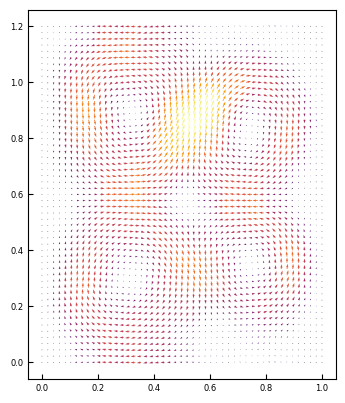

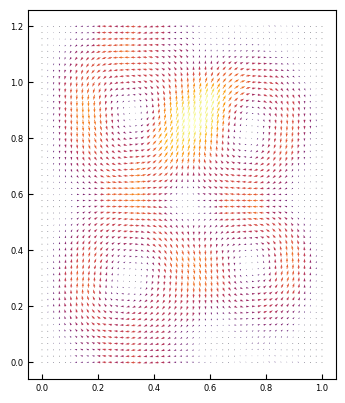

In [22]:
from fenics import RectangleMesh, Point, SubDomain, DOLFIN_EPS

mesh = RectangleMesh(Point(0., 0.), Point(1., 1.2), 48, 54)

class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return bool((x[0] < (DOLFIN_EPS) or \
                     x[0] > (1. - DOLFIN_EPS)) and \
                    on_boundary)

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Bottom boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[1] < (0 + DOLFIN_EPS) and \
                    x[1] > (0 - DOLFIN_EPS) and \
                    on_boundary)

    # Map top boundary (H) to bottom boundary (G)
    def map(self, x, y):
        y[0] = x[0]
        y[1] = x[1] - 1.2

from fenics import VectorElement, FiniteElement, FunctionSpace, Constant, DirichletBC
v1 = VectorElement('Lagrange', mesh.ufl_cell(), 1)
s1 = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
th = v1 * s1

W = FunctionSpace(mesh, th, constrained_domain=PeriodicBoundary())
V1 = FunctionSpace(mesh, v1)
bc = DirichletBC(W.sub(0), Constant((0., 0.)), DirichletBoundary())

from fenics import dof_to_vertex_map, Function, project
from scipy.interpolate import RectBivariateSpline
verts = mesh.coordinates()
    
dm_vs = np.zeros_like(verts)
dm_vs[:, 1] = RectBivariateSpline(
    np.linspace(0, 1.2, 236),
    np.linspace(0, 1, 200),
    div_m[20, 0])(verts[:, 1], verts[:, 0], grid=False)
dm_vs[:, 0] = RectBivariateSpline(
    np.linspace(0, 1.2, 236),
    np.linspace(0, 1, 200),
    div_m[20, 1])(verts[:, 1], verts[:, 0], grid=False)

d2v = dof_to_vertex_map(V1)
f = Function(V1)
f.vector().set_local(dm_vs.flatten()[d2v])
f = project(f, FunctionSpace(mesh, v1, constrained_domain=PeriodicBoundary()))

from fenics import TrialFunctions, TestFunctions, CellDiameter
u, p = TrialFunctions(W)
v, q = TestFunctions(W)

#Stabilized formulation for first-order elements
beta = 0.2
h = CellDiameter(mesh)
delta = beta * h * h

from fenics import inner, grad, div, dx
a = inner(grad(u), grad(v)) * dx + div(v) * p * dx + q * div(u) * dx + delta * inner(grad(p), grad(q)) * dx
L = -inner(-f, v) * dx + delta * inner(-f, grad(q)) * dx

from fenics import assemble_system, plot

A, bb = assemble_system(a, L, [bc])

#Using Krylov subspace method and preconditioner
from fenics import KrylovSolver

b = inner(grad(u), grad(v)) * dx + p * q * dx
P, _  = assemble_system(b, L, [bc])

solver = KrylovSolver('minres', 'amg')
solver.set_operators(A, P)

U = Function(W)
solver.solve(U.vector(), bb)
v1, p = U.split()
plt.figure()
plot(v1)

from scipy import sparse
#Assemble and solve directly without Krylov iterative solver
A = sparse.csr_matrix(np.asarray(A.array()))
L = sparse.csr_matrix(np.asarray(bb)).T

U = Function(W)
U.vector().set_local(sparse.linalg.spsolve(A, L))
v1, p = U.split()
plt.figure()
plot(v1)

# Compressible Stokes equation

99.99996940977731
(2695, 2)


Text(0.5, 1.0, 'V (fenics)')

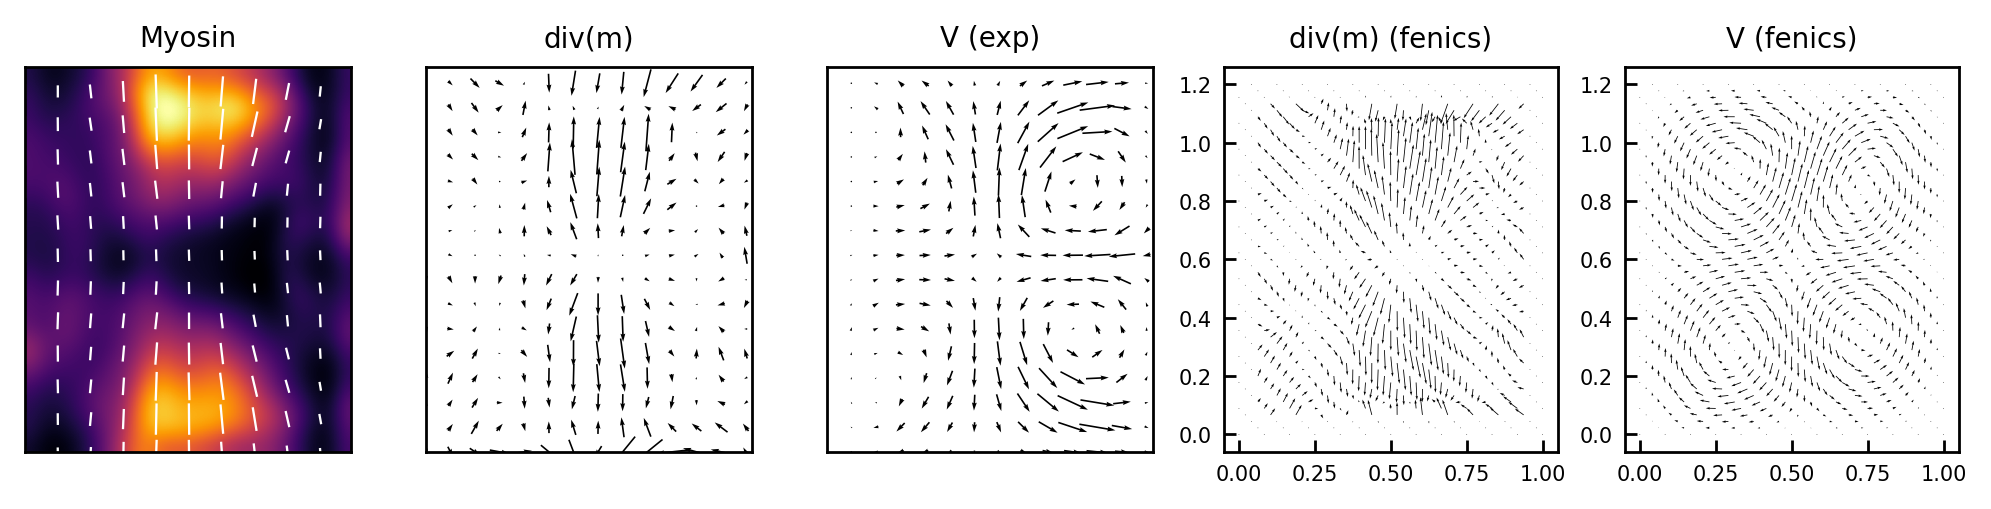

In [50]:
#Solve system exactly
from fenics import interpolate, project
from fenics import inner, grad, dot, div, dx
from fenics import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from fenics import FunctionSpace, VectorElement, TensorElement, MixedElement
from fenics import Mesh, Expression, Constant
from fenics import vertex_to_dof_map, dof_to_vertex_map
from fenics import VectorElement, FiniteElement, FunctionSpace, Constant, DirichletBC
from fenics import Function, assemble_system


from fenics import assemble
from scipy import sparse
from scipy.sparse.linalg import spsolve

from fenics import RectangleMesh, Point, SubDomain, DOLFIN_EPS

mesh = RectangleMesh(Point(0., 0.), Point(1., 1.2), 48, 54)

class DirichletBoundaryAP(SubDomain):
    def inside(self, x, on_boundary):
        return bool((x[0] < (DOLFIN_EPS) or \
                     x[0] > (1. - DOLFIN_EPS)) and \
                    on_boundary)
class DirichletBoundaryDV(SubDomain):
    def inside(self, x, on_boundary):
        return bool((x[1] < (DOLFIN_EPS) or \
                     x[1] > (1.2 - DOLFIN_EPS)) and \
                    on_boundary)

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Bottom boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[1] < (0 + DOLFIN_EPS) and \
                    x[1] > (0 - DOLFIN_EPS) and \
                    on_boundary)

    # Map top boundary (H) to bottom boundary (G)
    def map(self, x, y):
        y[0] = x[0]
        y[1] = x[1] - 1.2

plt.rcParams['font.size'] = 6

def solve_compressible_stokes(div_m, time=0, alpha=1.):
    eta = (1 + np.tanh((time-5)/2)) * 50
    print(eta)

    u = TrialFunction(V1)
    v = TestFunction(V1)
    f = Function(V1)
    A1 = -inner(grad(u), grad(v)) * dx(domain=mesh)
    A2 = -div(u) * div(v) * dx(domain=mesh)
    B = inner(u, v) * dx(domain=mesh)
    L = inner(f, v) * dx(domain=mesh)

    A1, _ = assemble_system(A1, L, bcs)
    A2, _ = assemble_system(A2, L, bcs)
    B, _ = assemble_system(B, L, bcs)

    A1 = sparse.csr_matrix(np.array(A1.array()))
    A2 = sparse.csr_matrix(np.array(A2.array()))
    B = sparse.csr_matrix(np.array(B.array()))

    verts = mesh.coordinates()
    dm_vs = np.zeros_like(verts)
    div_m = div_m.copy()
    div_m[:, :, :10] = 0.
    div_m[:, :, -10:] = 0.
    div_m[:, :10, :] = 0.
    div_m[:, -10:, :] = 0.
    dm_vs[:, 1] = RectBivariateSpline(
        np.linspace(0, 1.2, 236),
        np.linspace(0, 1, 200),
        div_m[0])(verts[:, 1], verts[:, 0], grid=False)
    dm_vs[:, 0] = RectBivariateSpline(
        np.linspace(0, 1.2, 236),
        np.linspace(0, 1, 200),
        div_m[1])(verts[:, 1], verts[:, 0], grid=False)

    d2v = dof_to_vertex_map(V1)
    v2d = vertex_to_dof_map(V1)
    dm_vs = dm_vs.flatten()[d2v]

    L = B.dot(-alpha * dm_vs)

    v1 = spsolve(A1 + eta * A2, L)[v2d]
    dm_vs = dm_vs[v2d]
    
    return v1.reshape([-1, 2]), dm_vs.reshape([-1, 2])


mesh = RectangleMesh(Point(0., 0.), Point(1., 1.2), 48, 54)
v1 = VectorElement('Lagrange', mesh.ufl_cell(), 1)
V1 = FunctionSpace(mesh, v1)
bcs = [
    DirichletBC(V1, Constant((0., 0.)), DirichletBoundaryDV()),
    DirichletBC(V1, Constant((0., 0.)), DirichletBoundaryAP()),
]

tt = 25

v1, dm_vs = solve_compressible_stokes(div_m[tt], 20)

from morphogenesis.plot_utils import plot_tensor, plot_vector, dv_min, dv_max, ap_min, ap_max

fig, ax = plt.subplots(1, 5, dpi=250, figsize=(10, 2))

plot_tensor(ax[0], m0[tt])
plot_vector(ax[1], div_m[tt], skip=15)
plot_vector(ax[2], v0[tt], skip=15)

cc = mesh.coordinates()
Nv = cc.shape[0]
skip=4
ax[3].quiver(cc[::skip,0], cc[::skip,1], dm_vs[::skip,0], dm_vs[::skip,1])
ax[4].quiver(cc[::skip,0], cc[::skip,1], v1[::skip,0], v1[::skip,1])
print(v1.shape)
for a in ax[:-2]:
    a.set(ylim=[dv_min, dv_max])
ax[0].set_title('Myosin')
ax[1].set_title('div(m)')
ax[2].set_title('V (exp)')
ax[3].set_title('div(m) (fenics)')
ax[4].set_title('V (fenics)')

3.059022269380485e-05
Time = -10, v0 = 0.614198, div_m = 5.35993e-05
0.6692850924284843
Time = 0, v0 = 1.02852, div_m = 0.000124131
99.33071490757152
Time = 10, v0 = 0.759885, div_m = 0.000283232
99.99996940977731
Time = 20, v0 = 1.47318, div_m = 0.000488974


Text(0.5, 1.0, 'V (stokes)')

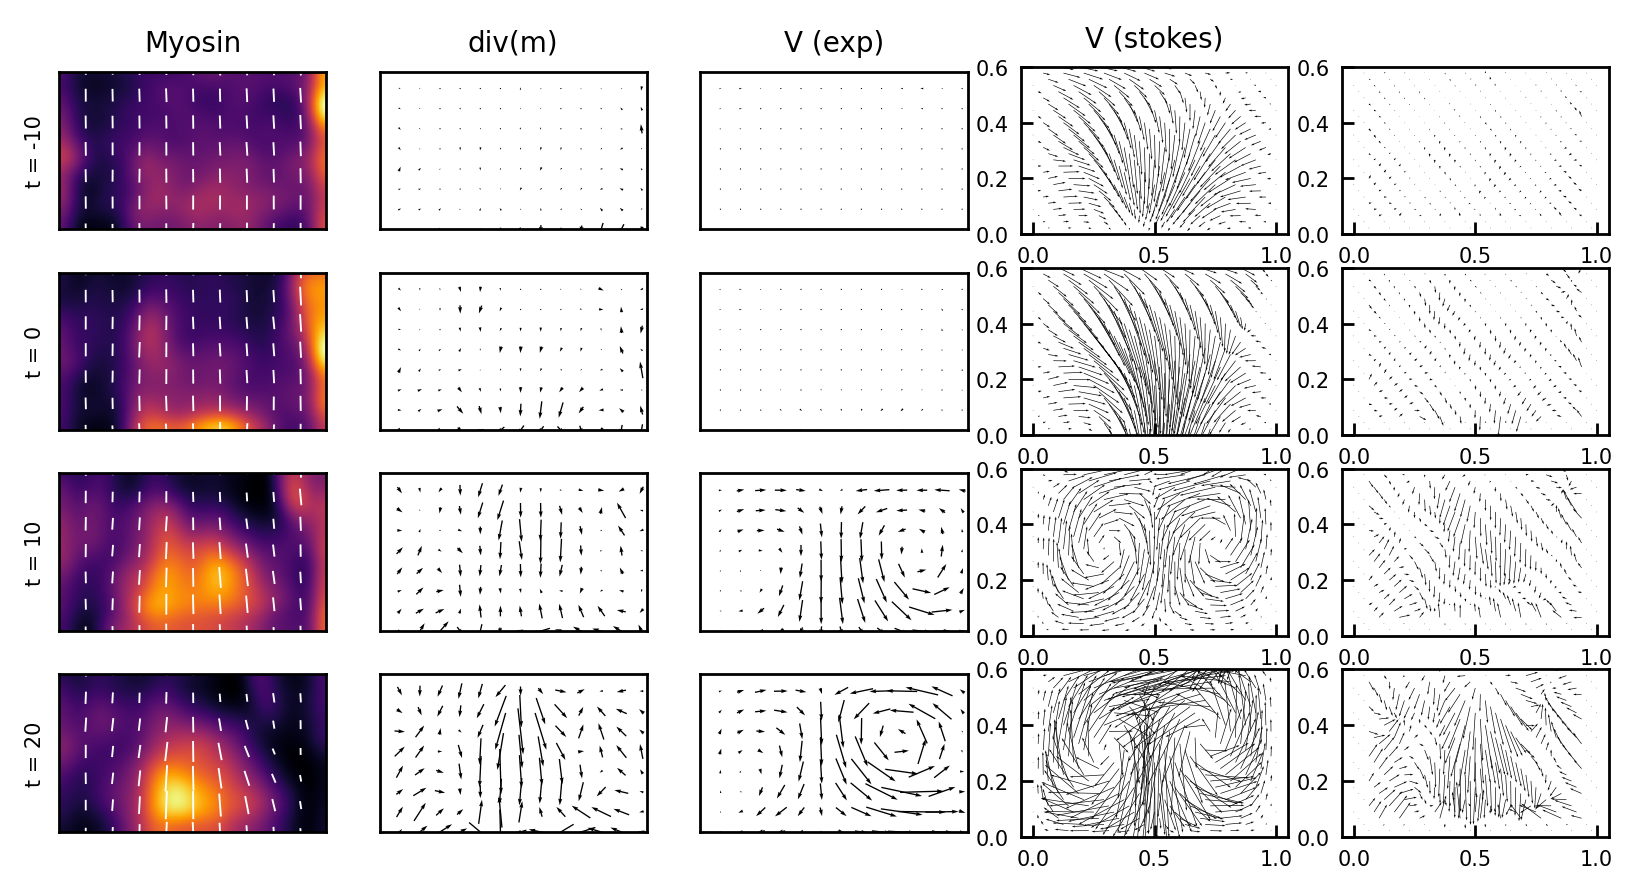

In [58]:
fig, ax = plt.subplots(4, 5, dpi=250, figsize=(8, 4))
for i, t in enumerate([0, 10, 20, 30]):

    time = t0[t]
    v1, d2m = solve_compressible_stokes(div_m[t], time, alpha=8e5)

    plot_tensor(ax[i, 0], m0[t])
    plot_vector(ax[i, 1], div_m[t], skip=15, scale=1e-2)
    plot_vector(ax[i, 2], v0[t], skip=15, scale=5e1)

    cc = mesh.coordinates()
    Nv = cc.shape[0]
    skip=4
    ax[i,3].quiver(cc[::skip,0], cc[::skip,1], v1[::skip,0], v1[::skip,1], scale=1e1)
    ax[i,4].quiver(cc[::skip,0], cc[::skip,1], d2m[::skip,0], d2m[::skip,1], scale=1e-2)

    ax[i,3].set_ylim([0, 0.6])
    ax[i,4].set_ylim([0, 0.6])

    print(f'Time = {time}, v0 = {np.linalg.norm(v1, axis=1).mean():3g}, div_m = {np.linalg.norm(d2m, axis=1).mean():3g}')
    ax[i,0].set_ylabel(f't = {time:d}')
ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('div(m)')
ax[0, 2].set_title('V (exp)')
ax[0, 3].set_title('V (stokes)')